In [55]:
import os.path
import json
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['fivethirtyeight'])

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [56]:
figdir = 'figures/disk_key_value_readonly'
!mkdir -p $figdir

In [57]:
duration_seconds = 10

results = []
with open('../benchmarks/disk_key_value/readonly/local_2020_04_15.jsonl', 'rt') as fp:
    for line in fp:
        spec, counts = json.loads(line)
        spec.update(counts)
        results.append(spec)
results = pd.DataFrame(results)

results['index'] = results['index_path'].map(os.path.basename)
results = results.drop(['data_path', 'known_keys_data_path', 'key_set_size', 'index_path'], axis=1)


results.sample(5)

,known_key_get_frac,read_threads,seconds,trial_index,get,found,index
10,0.9,4,10,7,2032994,1829431,index10
135,0.1,4,10,8,1965926,196676,index10
34,0.9,16,10,9,53412,48143,index1000
112,0.1,4,10,1,1965163,196811,index10
104,0.9,16,10,1,534497,481054,index100


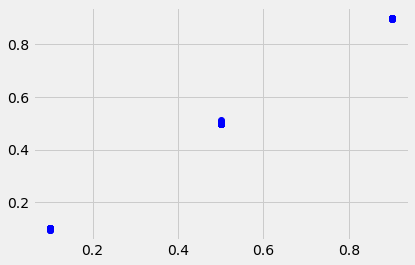

In [58]:
plt.plot(results['known_key_get_frac'], results['found'] / results['get'], 'bo')

In [59]:
x = results.copy()
x['get'] /= (duration_seconds * 1000)
agg = x.groupby(['index', 'known_key_get_frac', 'read_threads'])['get'].describe()
agg

count        mean        std  \
index     known_key_get_frac read_threads                                 
index10   0.1                1               7.0   44.992486   0.880440   
                             4               5.0  197.401680   4.371844   
                             16              4.0  346.654925  21.452009   
                             64              3.0  343.348267  17.753835   
          0.5                1               4.0   45.975725   0.566441   
                             4               5.0  201.206860   2.668225   
                             16              6.0  364.236283  14.754369   
                             64              4.0  344.167875  18.119778   
          0.9                1               4.0   46.781275   1.296874   
                             4               8.0  207.564000   2.860425   
                             16              6.0  384.933850  13.989478   
                             64              4.0  362.094425  12.951789   
index100  0.1                1               6.0    5.639583   0.084581   
                             4               4.0   27.264900   0.845962   
                             16              8.0   52.196225   2.329871   
                             64              6.0   51.834100   1.975179   
          0.5                1               6.0    5.822217   0.093973   
                             4               6.0   28.433433   0.470013   
                             16              3.0   53.029733   0.631670   
                             64              5.0   52.289080   3.007424   
          0.9                1               4.0    6.697950   0.168674   
                             4               4.0   28.602025   0.186586   
                             16              3.0   54.383200   2.453657   
                             64              2.0   53.943750   0.253215   
index1000 0.1                1               6.0    0.608750   0.034331   
                             4               6.0    2.692283   0.136167   
                             16              4.0    5.266575   0.414344   
                             64              6.0    5.575367   0.415101   
          0.5                1               3.0    0.658800   0.032566   
                             4               5.0    2.815440   0.161263   
                             16              5.0    5.387680   0.201543   
                             64              6.0    5.625267   0.212556   
          0.9                1               6.0    0.777400   0.015560   
                             4               7.0    3.155800   0.088170   
                             16              5.0    5.533820   0.391082   
                             64              4.0    5.715800   0.338220   

                                                min         25%        50%  \
index     known_key_get_frac read_threads                                    
index10   0.1                1              43.8588   44.417950   45.00210   
                             4             190.9474  196.516300  196.59260   
                             16            321.6085  335.726575  346.04990   
                             64            330.3962  333.229450  336.06270   
          0.5                1              45.3423   45.713700   45.92470   
                             4             197.1213  200.293000  201.89990   
                             16            347.1417  351.823225  364.55945   
                             64            317.2171  342.853000  351.49305   
          0.9                1              45.4726   45.764800   46.84935   
                             4             203.2994  205.640625  207.76290   
                             16            360.3381  381.273825  386.65420   
                             64            343.6792  358.304125  365.70570   
index100  0.1                1               5.5683    5.590575    5.61305   
                      

Text(0.5, 0, 'Concurrent Reading Threads')

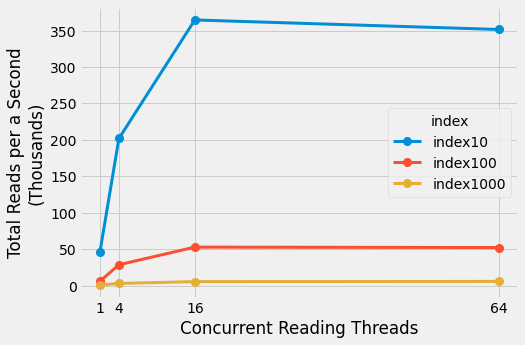

In [60]:
x = agg.reset_index()
x = x[x['known_key_get_frac'] == 0.5]
x = x.groupby(['index', 'read_threads'])['50%'].apply(lambda x: x.iloc[0]).unstack().T
x
x.plot(lw=3, ms=8, marker='o', figsize=(7, 5))
plt.xticks([1, 4, 16, 64])
plt.ylabel('Total Reads per a Second\n(Thousands)')
plt.xlabel('Concurrent Reading Threads')

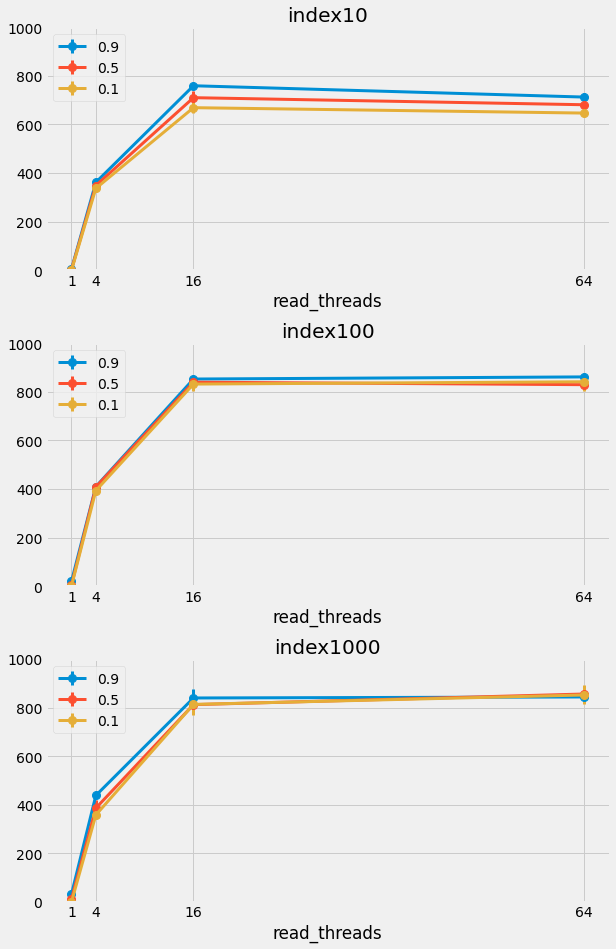

In [61]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(hspace=0.3)
for i,(index, x) in enumerate(agg.reset_index().groupby('index')):
    ax = fig.add_subplot(3, 1, i+1)
    ax.set_title(index)
    t0 = x['50%'].min()
    for kkgf, x in list(x.groupby('known_key_get_frac'))[::-1]:
        x = x.set_index('read_threads')
        for c in '25%', '50%', '75%':
            x[c] /= t0
            x[c] -= 1
            x[c] *= 100
        iq = x[['25%', '75%']].copy()
        iq['25%'] = x['50%'] - iq['25%']
        iq['75%'] -= x['50%']

        x.plot(ax=ax, y='50%', yerr=iq.values.T, label=kkgf, marker='o', ms=8, lw=3)
        ax.set_ylim(0, 1000)
        ax.set_xticks([1, 4, 16, 64])
        ax.legend(loc='upper left')